# Description

This notebook is used to request computation of average time-series of a WaPOR data layer for an area using WaPOR API.

You will need WaPOR API Token to use this notebook (https://github.com/trngbich/examples_WaPOR_API/blob/master/README.md)

# Step 1: Read APIToken

Get your APItoken from https://wapor.apps.fao.org/profile. Enter your API Token when running the cell below.

In [1]:
import requests
import pandas as pd

path_query=r'https://io.apps.fao.org/gismgr/api/v1/query/'
path_sign_in=r'https://io.apps.fao.org/gismgr/api/v1/iam/sign-in/'

APIToken=input('Your API token: ')

Your API token: Enter Your API Token when run this cell


# Step 2: Get Authorization AccessToken

Using the input API token to get AccessToken for authorization

In [2]:
resp_signin=requests.post(path_sign_in,headers={'X-GISMGR-API-KEY':APIToken})
resp_signin = resp_signin.json()
AccessToken=resp_signin['response']['accessToken']

# Step 3: Post Query Load

For more examples of areatimeseries query load 
visit https://io.apps.fao.org/gismgr/api/v1/swagger-ui/examples/AreaStatsTimeSeries.txt

## Define area by coordinate extent

In [3]:
bbox= [37.95883206252312, 7.89534, 43.32093, 12.3873979377346] #latlon
xmin,ymin,xmax,ymax=bbox[0],bbox[1],bbox[2],bbox[3]
Polygon=[
          [xmin,ymin],
          [xmin,ymax],
          [xmax,ymax],
          [xmax,ymin],
          [xmin,ymin]
        ]
query_areatimeseries={
  "type": "AreaStatsTimeSeries",
  "params": {
    "cube": {
      "code": "L1_PCP_E", #cube_code
      "workspaceCode": "WAPOR", #workspace code: use WAPOR for v1.0 and WAPOR_2 for v2.1
      "language": "en"
    },
    "dimensions": [
      {
        "code": "DAY", #use DAY DEKAD MONTH or YEAR
        "range": "[2017-01-01,2018-01-01)" #start date and endate
      }
    ],
    "measures": [
      "WATER_MM"
    ],
    "shape": {
      "type": "Polygon",
      "properties": {
      "name": "epsg:4326" #latlon projection
              },
      "coordinates": [
       Polygon
      ]
    }
  }
}



## OR define area by reading GeoJSON

In [ ]:
import ogr
shp_fh=r"D:\Folder\shapefile.shp"

shpfile=ogr.Open(shp_fh)
layer=shpfile.GetLayer()
epsg_code=layer.GetSpatialRef().GetAuthorityCode(None)
shape=layer.GetFeature(0).ExportToJson(as_object=True)['geometry']
shape["properties"]={"name": "EPSG:{0}".format(epsg_code)}#latlon projection            

query_areatimeseries={
  "type": "AreaStatsTimeSeries",
  "params": {
    "cube": {
      "code": "L1_PCP_E",
      "workspaceCode": "WAPOR_2",
      "language": "en"
    },
    "dimensions": [
      {
        "code": "DAY",
        "range": "[2017-01-01,2018-01-01)"
      }
    ],
    "measures": [
      "WATER_MM"
    ],
    "shape": shape
  }
}



In [ ]:
query_areatimeseries

# Post the QueryPayload with AccessToken in Header 

In responses, get an url to query job. 

In [4]:
resp_query=requests.post(path_query,headers={'Authorization':'Bearer {0}'.format(AccessToken)},
                                          json=query_areatimeseries)
resp_query = resp_query.json()
job_url=resp_query['response']['links'][0]['href']

job_url

'https://io.apps.fao.org/gismgr/api/v1/catalog/workspaces/WAPOR/jobs/40751bd0-bcff-4cb3-b856-33e5e0ae9aaf'

# Step 4: Get Job Results.

It will take some time for the job to be finished. When the job is finished, its status will be changed from 'RUNNING' to 'COMPLETED' or 'COMPLETED WITH ERRORS'. If it is COMPLETED, the area time series results can be achieved from Response 'output'.

In [5]:
i=0
print('RUNNING',end=" ")
while i==0:        
    resp = requests.get(job_url)
    resp=resp.json()
    
    if resp['response']['status']=='RUNNING':
        print('.',end =" ")
    if resp['response']['status']=='COMPLETED':
        results=resp['response']['output']
        df=pd.DataFrame(results['items'],columns=results['header'])
        i=1
    if resp['response']['status']=='COMPLETED WITH ERRORS':
        print(resp['response']['log'])
        i=1       
df

RUNNING 

,day,avg,min,max,range
0,2017-01-01,0.158715,0.0,6.7,6.7
1,2017-01-02,0.205504,0.0,6.5,6.5
2,2017-01-03,0.416010,0.0,7.5,7.5
3,2017-01-04,0.000000,0.0,0.0,0.0
4,2017-01-05,0.000000,0.0,0.0,0.0
5,2017-01-06,0.000961,0.0,5.0,5.0
6,2017-01-07,0.032021,0.0,5.3,5.3
7,2017-01-08,0.167530,0.0,6.5,6.5
8,2017-01-09,0.058632,0.0,5.8,5.8
9,2017-01-10,0.204700,0.0,8.4,8.4


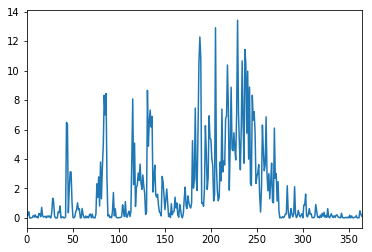

In [7]:
df.avg.plot()